In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from generate_data import UserGenerator

In [9]:
generator_data = UserGenerator(seed=42, n_samples=10000)
df = generator_data.create_dataset()

df.head()

Generando datos sintéticos de usuarios para targeting de promociones...


,user_id,age_group,location,device_type,subscription_type,days_since_registration,total_purchases,avg_order_value,last_purchase_days,sessions_last_30_days,time_on_site_minutes,pages_per_session,cart_abandonment_rate,purchase_frequency,dar_promocion
0,USER-000001,18-25,Mendoza,Mobile,Free,38,6,341.58,139,2,71.3,1.6,0.075,4.74,1
1,USER-000002,26-35,Buenos Aires,Mobile,Basic,246,34,215.56,114,18,34.1,17.5,0.607,4.15,0
2,USER-000003,36-45,Buenos Aires,Mobile,Enterprise,284,21,60.08,97,3,43.7,7.5,0.212,2.22,1
3,USER-000004,36-45,Cordoba,Tablet,Free,343,35,153.66,160,19,106.4,7.9,0.154,3.06,0
4,USER-000005,18-25,Buenos Aires,Mobile,Free,330,14,434.58,97,8,55.0,16.8,0.130,1.27,1


### 1. Haz un EDA... entiende los datos

<Axes: >

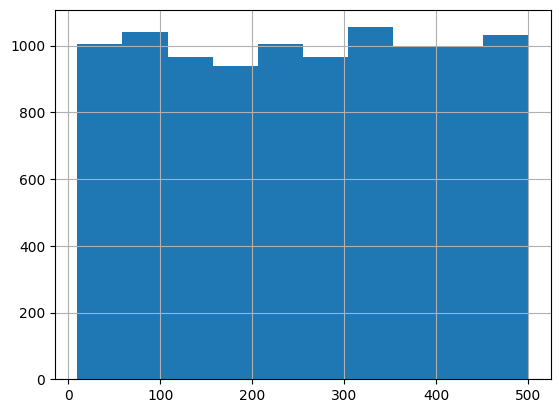

In [10]:
df.avg_order_value.hist()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  10000 non-null  object 
 1   age_group                10000 non-null  object 
 2   location                 10000 non-null  object 
 3   device_type              10000 non-null  object 
 4   subscription_type        10000 non-null  object 
 5   days_since_registration  10000 non-null  int64  
 6   total_purchases          10000 non-null  int64  
 7   avg_order_value          10000 non-null  float64
 8   last_purchase_days       10000 non-null  int64  
 9   sessions_last_30_days    10000 non-null  int64  
 10  time_on_site_minutes     10000 non-null  float64
 11  pages_per_session        10000 non-null  float64
 12  cart_abandonment_rate    10000 non-null  float64
 13  purchase_frequency       10000 non-null  float64
 14  dar_promocion          

### 2.  Crea más features....

In [13]:
# we can create new columns with existing columns
df['total_purchases_per_day'] = df['total_purchases'] / df['days_since_registration']

df["days_between_first_and_last_purchase"] = df["days_since_registration"] - df["last_purchase_days"]

df["bucket_avg_order_value"] = pd.cut(df["avg_order_value"], bins=3, labels=["low", "medium", "high"])

### 3. Define split de datos

In [14]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["dar_promocion"]), df["dar_promocion"], test_size=0.2, random_state=42)

### 4. Crea un pipeline de procesamiento y train

Las variables numericas decidimos:

1. Imputar con mediana... pero podria ser con 0, con promedio, con moda... probemos
2. Usar standardscaler, pero podemos usar cualquier tipo de estandarización

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Define numeric and categorical columns
numeric_features = ['days_since_registration', 'total_purchases', 'avg_order_value', 
                   'last_purchase_days', 'sessions_last_30_days', 'time_on_site_minutes', 
                   'pages_per_session', 'cart_abandonment_rate', 'purchase_frequency']

# Create preprocessing pipelines for each data type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

Las variables categoricas decidimos:

1. Imputar con "unknow"...
2. Usar OneHotEncoder

In [19]:
categorical_features = ['age_group', 'location', 'device_type', 'subscription_type']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

Luego unimos ambas transformaciones en un ColumnTransformer para aplicarselo a todo el df

In [20]:
# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop any columns not specified above
)

Usamos el column transformer y luego entrenamos una regresión logistica. 

In [21]:
# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [22]:
# Fit the pipeline
pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Predecimos

In [23]:

# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

Estas son las metricas

In [26]:
# Evaluate
from sklearn.metrics import classification_report, roc_auc_score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ROC-AUC Score: 0.5148348553827932

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      1019
           1       0.50      0.52      0.51       981

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



## **Actividad**

Prueba:

1. Imputar los numericos con otras estrategias
2. Crea nuevas features
3. Usar BinaryEncoder para las categoricas
4. Usar MinMaxScaler para las numericas
5. Usar RandomForestClassifier para el modelo
6. Usar GridSearchCV para encontrar los mejores hiperparametros
7. Juega con el split de datos


Luego de hacer todas estas pruebas en el mismo notebook, crea un mensaje "resumen" de tus cambios y tus resultados. 